In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('dataset_2017_2020.csv')
df.head(5)

,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first
0,15803,1131974,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Baked bread/buns/rolls,374,2018-10-18 00:00:00,0.99,0
1,15803,1051516,57266,Loyalist,1 adult with kids,19-24,Produce,national,Vegetables - all others,374,2018-10-18 00:00:00,0.70,0
2,15803,967254,57266,Loyalist,1 adult with kids,19-24,Pharmaceutical,national,Cold and flu,374,2018-10-18 00:00:00,1.68,0
3,15803,1134222,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Paper housewares,374,2018-10-18 00:00:00,2.59,0
4,15803,1003421,57266,Loyalist,1 adult with kids,19-24,Grocery,national,Soup,374,2018-10-18 00:00:00,0.60,0


# Data Cleaning 

In [2]:
df.isnull().sum()

customer_id         0
product_id          0
basket_id           0
loyalty             0
household_type      0
age_band            0
department          0
brand               0
commodity           0
store               0
transaction_date    0
price               0
days_since_first    0
dtype: int64

it can be seen that the data hold no null values in any columns.

In [3]:
df.duplicated().sum()

1633

there are 1633 duplicated entries in the data. this should be handled. the adopted tecnique chosen to handle them is dropping.

In [4]:
print(len(df)) # lenght of data frame before dropping duplicates 
df.drop_duplicates(inplace = True)
print(len(df)) # lenght of data frame after dropping duplicates 

77750
76117


Now, the index is not has some missing numerals in the sequence. So, it is needed to have the sequence fixed.

In [5]:
df.reset_index(drop=True,inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76117 entries, 0 to 76116
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       76117 non-null  int64  
 1   product_id        76117 non-null  int64  
 2   basket_id         76117 non-null  int64  
 3   loyalty           76117 non-null  object 
 4   household_type    76117 non-null  object 
 5   age_band          76117 non-null  object 
 6   department        76117 non-null  object 
 7   brand             76117 non-null  object 
 8   commodity         76117 non-null  object 
 9   store             76117 non-null  int64  
 10  transaction_date  76117 non-null  object 
 11  price             76117 non-null  float64
 12  days_since_first  76117 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 7.5+ MB


it can be seen that data needed for analysis was in the right data types either being strings or even numerals. this ensures that data analyst modular data and ready to have investigation done.

the next stage is to make the data ready for anlysis. it was chosen to handle the data on monthly basis. so, all trasaction dates of the month are shifted back to the month opening.

In [7]:
df['transaction_date'] = df.transaction_date.str[:10] #avoid time in date
df['t_date'] = pd.to_datetime(df.transaction_date) #convert to date format
df['t_date'] = df.t_date + pd.offsets.MonthBegin(-1) #send dates to first day of the month

### customers segmentations based on loyality


In [8]:
df.loyalty.unique()


array(['Loyalist', 'Promiscuous', 'First Time Buyer'], dtype=object)

# For loyal customers 

In [9]:
dfilt = df[(df.loyalty ==  'Loyalist')]
dfilt.head()

,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
0,15803,1131974,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Baked bread/buns/rolls,374,2018-10-18,0.99,0,2018-10-01
1,15803,1051516,57266,Loyalist,1 adult with kids,19-24,Produce,national,Vegetables - all others,374,2018-10-18,0.70,0,2018-10-01
2,15803,967254,57266,Loyalist,1 adult with kids,19-24,Pharmaceutical,national,Cold and flu,374,2018-10-18,1.68,0,2018-10-01
3,15803,1134222,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Paper housewares,374,2018-10-18,2.59,0,2018-10-01
4,15803,1003421,57266,Loyalist,1 adult with kids,19-24,Grocery,national,Soup,374,2018-10-18,0.60,0,2018-10-01


In [10]:
#Find the top 5 selling departments by revenue. There is a total of 11 departments
top_5d = dfilt.groupby(['department']).agg(total_revenue=('price',sum)) \
    .sort_values('total_revenue', ascending = False).reset_index().head(5)
top_5d

,department,total_revenue
0,Grocery,25672.10
1,Meat,20523.79
2,Pharmaceutical,17663.22
3,Produce,14860.19
4,Deli,5962.44


In [11]:
# Get the top selling commodities in the top 5 departments
tmp = dfilt[dfilt.department.isin(top_5d.department.unique())].groupby(['department', 'commodity']).agg(total_revenue=('price', sum)).reset_index()
top_5c = pd.concat(
    [tmp[tmp.department == hh] \
         .sort_values('total_revenue', ascending=False) \
     .head(5) for hh in top_5d.department.unique()]).reset_index(drop=True)
top_5c.head(15)

,department,commodity,total_revenue
0,Grocery,Soft drinks,1729.29
1,Grocery,Fluid milk products,1395.88
2,Grocery,Cheese,1243.60
3,Grocery,Frozen meat,1141.84
4,Grocery,Baked bread/buns/rolls,969.23
5,Meat,Beef,6678.30
6,Meat,Lunch meat,2242.44
7,Meat,Pork,2007.33
8,Meat,Chicken,1669.02
9,Meat,Meat - Other,1406.66


# For grocery trend commodities 

In [12]:
top_5c[:5]

,department,commodity,total_revenue
0,Grocery,Soft drinks,1729.29
1,Grocery,Fluid milk products,1395.88
2,Grocery,Cheese,1243.60
3,Grocery,Frozen meat,1141.84
4,Grocery,Baked bread/buns/rolls,969.23


In [13]:
grocery =  dfilt[dfilt.department == 'Grocery'][dfilt.commodity.str.contains('Soft drinks|Fluid milk products|Cheese|Frozen meat|Baked bread/buns/rolls')].copy()
grocery.head(5)

<ipython-input-13-dabd4d600ce7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grocery =  dfilt[dfilt.department == 'Grocery'][dfilt.commodity.str.contains('Soft drinks|Fluid milk products|Cheese|Frozen meat|Baked bread/buns/rolls')].copy()


,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
0,15803,1131974,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Baked bread/buns/rolls,374,2018-10-18,0.99,0,2018-10-01
44,15815,951590,52250,Loyalist,Single female,19-24,Grocery,national,Baked bread/buns/rolls,374,2019-08-18,3.00,0,2019-08-01
46,15815,859075,52250,Loyalist,Single female,19-24,Grocery,private,Cheese,374,2019-08-18,5.00,0,2019-08-01
47,15815,16769526,52250,Loyalist,Single female,19-24,Grocery,national,Baked bread/buns/rolls,374,2019-08-18,2.50,0,2019-08-01
49,15815,1136257,52250,Loyalist,Single female,19-24,Grocery,private,Cheese,374,2019-08-18,1.50,0,2019-08-01


In [14]:
grocery_ts = grocery.groupby(['t_date']).agg(total_revenue=('price', sum))
grocery_ts.tail()

,total_revenue
t_date,
2020-01-01,164.97
2020-02-01,132.49
2020-03-01,138.13
2020-04-01,189.57
2020-05-01,148.03


In [15]:
# Calculating the 6month Moving Average 
grocery_tail = grocery_ts.rolling(window=6) 
moving_avg = grocery_tail.mean()
moving_avg.tail(5)

,total_revenue
t_date,
2020-01-01,167.333333
2020-02-01,160.515000
2020-03-01,154.648333
2020-04-01,168.913333
2020-05-01,170.075000


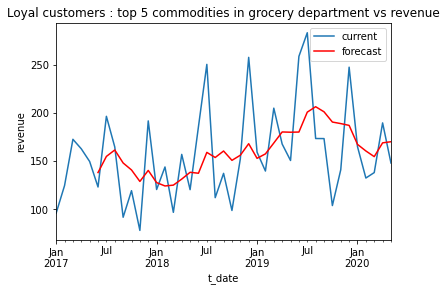

In [16]:
fig, ax = plt.subplots(1,1)
grocery_ts.plot(ax=ax);
moving_avg.plot(color = 'red', ax=ax)
plt.title('Loyal customers : top 5 commodities in grocery department vs revenue')
plt.ylabel('revenue')
plt.legend(['current','forecast'])
plt.show();

the top 5 commodities in grocery department figure shows that the need for those commodites increase in the second half of the year. this can be followed by suitable supply and marketing campaigns.

In [17]:
top_5c[:5]

,department,commodity,total_revenue
0,Grocery,Soft drinks,1729.29
1,Grocery,Fluid milk products,1395.88
2,Grocery,Cheese,1243.60
3,Grocery,Frozen meat,1141.84
4,Grocery,Baked bread/buns/rolls,969.23


## For meat trend commodities


In [18]:
top_5c[5:10]

,department,commodity,total_revenue
5,Meat,Beef,6678.30
6,Meat,Lunch meat,2242.44
7,Meat,Pork,2007.33
8,Meat,Chicken,1669.02
9,Meat,Meat - Other,1406.66


In [19]:
meat = dfilt[dfilt.department == 'Meat'][dfilt.commodity.str.contains('Lunch meat|Beef|Chicken|Meat - Other|Pork')].copy()
meat.head()

<ipython-input-19-c56576184107>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meat = dfilt[dfilt.department == 'Meat'][dfilt.commodity.str.contains('Lunch meat|Beef|Chicken|Meat - Other|Pork')].copy()


,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
14,15803,871909,57266,Loyalist,1 adult with kids,19-24,Meat,national,Lunch meat,374,2018-10-18,1.99,0,2018-10-01
16,15803,1021519,57266,Loyalist,1 adult with kids,19-24,Meat,national,Beef,374,2018-10-18,2.54,0,2018-10-01
55,15815,13007721,52250,Loyalist,Single female,19-24,Meat,national,Beef,374,2019-08-18,7.99,0,2019-08-01
59,15815,871611,52250,Loyalist,Single female,19-24,Meat,national,Chicken,374,2019-08-18,5.12,0,2019-08-01
78,15818,9245106,62607,Loyalist,2 adults with no kids,19-24,Meat,national,Beef,374,2017-12-18,6.13,65,2017-12-01


In [20]:
meat_ts = meat.groupby(['t_date']).agg(total_revenue=('price', sum))
meat_ts.tail()

,total_revenue
t_date,
2020-01-01,298.01
2020-02-01,318.44
2020-03-01,238.00
2020-04-01,392.18
2020-05-01,353.90


In [21]:
# Calculating the 6month Moving Average 
meat_tail = meat_ts.rolling(window=6) 
moving_avg = meat_tail.mean()
moving_avg.tail(5)

,total_revenue
t_date,
2020-01-01,316.856667
2020-02-01,309.605000
2020-03-01,296.611667
2020-04-01,328.135000
2020-05-01,329.701667


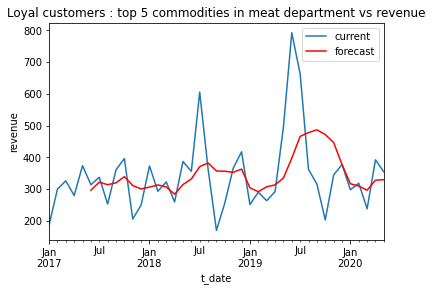

In [22]:
fig, ax = plt.subplots(1,1)
meat_ts.plot(ax=ax);
moving_avg.plot(color = 'red', ax=ax)
plt.title('Loyal customers : top 5 commodities in meat department vs revenue')
plt.ylabel('revenue')
plt.legend(['current','forecast'])
plt.show();

the top 5 commodities in meat department figure shows that the need of those commodities increase in the second half of the year then it decay till it reach the year opening. this can help supply chain desion makers and marketing team to have the most suitable time for suppying or having marketing campaigns.

In [23]:
top_5c[5:10]

,department,commodity,total_revenue
5,Meat,Beef,6678.30
6,Meat,Lunch meat,2242.44
7,Meat,Pork,2007.33
8,Meat,Chicken,1669.02
9,Meat,Meat - Other,1406.66


## For pharmaceutical trend commodities 

In [24]:
top_5c[10:15]

,department,commodity,total_revenue
10,Pharmaceutical,Candy,1996.21
11,Pharmaceutical,Cigarettes,1875.74
12,Pharmaceutical,Oral hygiene products,842.50
13,Pharmaceutical,Hair care products,833.17
14,Pharmaceutical,Diapers,677.61


In [25]:
pharmaceutical = dfilt[dfilt.department == 'Pharmaceutical'][dfilt.commodity.str.contains('Candy|Cigarettes|Oral hygiene products|Hair care products|Diapers')].copy()
pharmaceutical.head()

<ipython-input-25-895fbacbf979>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pharmaceutical = dfilt[dfilt.department == 'Pharmaceutical'][dfilt.commodity.str.contains('Candy|Cigarettes|Oral hygiene products|Hair care products|Diapers')].copy()


,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
64,15815,15596933,52250,Loyalist,Single female,19-24,Pharmaceutical,national,Candy,374,2019-08-18,1.00,0,2019-08-01
103,15822,17104127,52237,Loyalist,1 adult with kids,35-44,Pharmaceutical,national,Candy,374,2019-08-18,2.74,0,2019-08-01
144,15850,1014388,57357,Loyalist,1 adult with kids,25-34,Pharmaceutical,national,Cigarettes,374,2019-10-18,3.29,0,2019-10-01
173,15855,1103556,57399,Loyalist,Single male,19-24,Pharmaceutical,national,Candy,374,2019-10-18,0.66,16,2019-10-01
222,15861,1038691,62744,Loyalist,Single male,19-24,Pharmaceutical,national,Candy,374,2018-12-18,1.00,21,2018-12-01


In [26]:
pharmaceutical_ts = pharmaceutical.groupby(['t_date']).agg(total_revenue=('price', sum))
pharmaceutical_ts.tail()

,total_revenue
t_date,
2020-01-01,93.70
2020-02-01,165.04
2020-03-01,136.93
2020-04-01,91.32
2020-05-01,187.90


In [27]:
# Calculating the 6month Moving Average 
pharmaceutical_tail = pharmaceutical_ts.rolling(window=6) 
moving_avg = pharmaceutical_tail.mean()
moving_avg.tail(5)

,total_revenue
t_date,
2020-01-01,120.403333
2020-02-01,124.715000
2020-03-01,122.806667
2020-04-01,121.625000
2020-05-01,142.631667


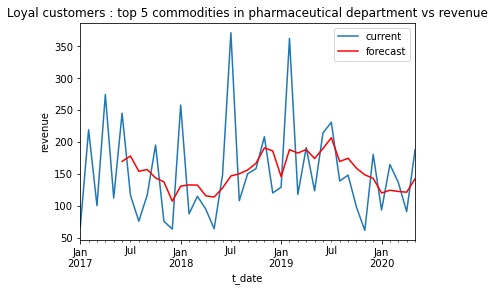

In [28]:
fig, ax = plt.subplots(1,1)
pharmaceutical_ts.plot(ax=ax);
moving_avg.plot(color = 'red', ax=ax)
plt.title('Loyal customers : top 5 commodities in pharmaceutical department vs revenue')
plt.ylabel('revenue')
plt.legend(['current','forecast'])
plt.show();

the top 5 commodities in pharmaceutical deparment figure shows that the need of those commodities are increasing in the first 6 months of the year. this can be followed up by the supply chain desion makers to ensure the existance of those commodities.

In [29]:
top_5c[10:15]

,department,commodity,total_revenue
10,Pharmaceutical,Candy,1996.21
11,Pharmaceutical,Cigarettes,1875.74
12,Pharmaceutical,Oral hygiene products,842.50
13,Pharmaceutical,Hair care products,833.17
14,Pharmaceutical,Diapers,677.61


# For First Time Buyers

In [30]:
dfilt = df[(df.loyalty ==  'First Time Buyer')]
dfilt.head()

,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
114,15847,8019087,52210,First Time Buyer,Single female,19-24,Grocery,national,Pet care supplies,374,2019-08-18,2.99,0,2019-08-01
115,15847,12386080,52210,First Time Buyer,Single female,19-24,Grocery,national,Frozen pizza,374,2019-08-18,2.00,0,2019-08-01
116,15847,5569471,52210,First Time Buyer,Single female,19-24,Grocery,national,Soft drinks,374,2019-08-18,4.19,0,2019-08-01
117,15847,1037863,52210,First Time Buyer,Single female,19-24,Produce,national,Vegetables - all others,374,2019-08-18,0.78,0,2019-08-01
118,15847,7169034,52210,First Time Buyer,Single female,19-24,Produce,private,Organic fruit/vegetables,374,2019-08-18,1.99,0,2019-08-01


In [31]:
#Find the top 5 selling departments by revenue. There is a total of 11 departments
top_5d = dfilt.groupby(['department']).agg(total_revenue=('price',sum)) \
    .sort_values('total_revenue', ascending = False).reset_index().head(5)
top_5d

,department,total_revenue
0,Grocery,888.52
1,Meat,701.58
2,Pharmaceutical,675.59
3,Produce,505.40
4,Pastry,202.88


In [32]:
# Get the top selling commodities in the top 5 departments
tmp = dfilt[dfilt.department.isin(top_5d.department.unique())].groupby(['department', 'commodity']).agg(total_revenue=('price', sum)).reset_index()
top_5c = pd.concat(
    [tmp[tmp.department == hh] \
         .sort_values('total_revenue', ascending=False) \
     .head(5) for hh in top_5d.department.unique()]).reset_index(drop=True)
top_5c.head(15)

,department,commodity,total_revenue
0,Grocery,Soft drinks,70.84
1,Grocery,Frozen meat,52.36
2,Grocery,Baked bread/buns/rolls,37.34
3,Grocery,Cheese,35.61
4,Grocery,Cereal,29.74
5,Meat,Beef,212.82
6,Meat,Lunch meat,93.46
7,Meat,Chicken,75.67
8,Meat,Pork,71.01
9,Meat,Meat - Other,60.90


##  For grocery trend commodities

In [33]:
top_5c[:5]

,department,commodity,total_revenue
0,Grocery,Soft drinks,70.84
1,Grocery,Frozen meat,52.36
2,Grocery,Baked bread/buns/rolls,37.34
3,Grocery,Cheese,35.61
4,Grocery,Cereal,29.74


In [34]:
grocery =  dfilt[dfilt.department == 'Grocery'][dfilt.commodity.str.contains('Soft drinks|Cereal|Cheese|Frozen meat|Baked bread/buns/rolls')].copy()
grocery.head(5)

<ipython-input-34-345b72741b00>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grocery =  dfilt[dfilt.department == 'Grocery'][dfilt.commodity.str.contains('Soft drinks|Cereal|Cheese|Frozen meat|Baked bread/buns/rolls')].copy()


,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
116,15847,5569471,52210,First Time Buyer,Single female,19-24,Grocery,national,Soft drinks,374,2019-08-18,4.19,0,2019-08-01
539,15909,1082172,57316,First Time Buyer,2 adults with no kids,19-24,Grocery,private,Cheese,374,2018-10-18,1.25,0,2018-10-01
4483,16640,919963,59928,First Time Buyer,1 adult with kids,19-24,Grocery,national,Cereal,374,2019-11-18,1.99,74,2019-11-01
4487,16640,13115659,59928,First Time Buyer,1 adult with kids,19-24,Grocery,national,Baked bread/buns/rolls,374,2019-11-18,2.99,74,2019-11-01
4488,16640,822226,59928,First Time Buyer,1 adult with kids,19-24,Grocery,national,Cheese,374,2019-11-18,2.99,74,2019-11-01


In [35]:
grocery_ts = grocery.groupby(['t_date']).agg(total_revenue=('price', sum))
grocery_ts.tail()

,total_revenue
t_date,
2019-08-01,10.39
2019-11-01,13.66
2019-12-01,13.07
2020-02-01,2.67
2020-04-01,9.00


In [36]:
# Calculating the 6month Moving Average 
grocery_tail = grocery_ts.rolling(window=6) 
moving_avg = grocery_tail.mean()
moving_avg.tail(5)

,total_revenue
t_date,
2019-08-01,8.975000
2019-11-01,8.836667
2019-12-01,9.265000
2020-02-01,9.153333
2020-04-01,9.423333


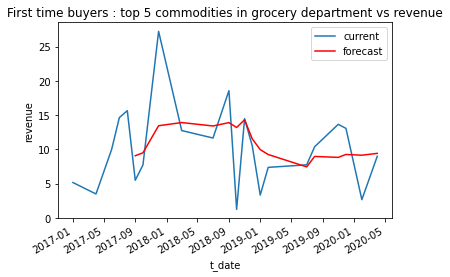

In [37]:
fig, ax = plt.subplots(1,1)
grocery_ts.plot(ax=ax);
moving_avg.plot(color = 'red', ax=ax)
plt.title('First time buyers : top 5 commodities in grocery department vs revenue')
plt.ylabel('revenue')
plt.legend(['current','forecast'])
plt.show();

the figure shows a noticeable increase in the grocery top 5 commodities starting at month 9 each year. this can be followed up by insurance in stock of those commodities in those periods. this can significantly turn first time buyers into loyal customers.


In [38]:
top_5c[:5]

,department,commodity,total_revenue
0,Grocery,Soft drinks,70.84
1,Grocery,Frozen meat,52.36
2,Grocery,Baked bread/buns/rolls,37.34
3,Grocery,Cheese,35.61
4,Grocery,Cereal,29.74


## For meat trend commodities


In [39]:
top_5c[5:10]

,department,commodity,total_revenue
5,Meat,Beef,212.82
6,Meat,Lunch meat,93.46
7,Meat,Chicken,75.67
8,Meat,Pork,71.01
9,Meat,Meat - Other,60.90


In [40]:
meat = dfilt[dfilt.department == 'Meat'][dfilt.commodity.str.contains('Lunch meat|Beef|Chicken|Meat - Other|Pork')].copy()
meat.head()

<ipython-input-40-c56576184107>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meat = dfilt[dfilt.department == 'Meat'][dfilt.commodity.str.contains('Lunch meat|Beef|Chicken|Meat - Other|Pork')].copy()


,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
542,15909,12262739,57316,First Time Buyer,2 adults with no kids,19-24,Meat,national,Beef,374,2018-10-18,18.70,0,2018-10-01
544,15909,12810422,57316,First Time Buyer,2 adults with no kids,19-24,Meat,national,Pork,374,2018-10-18,3.68,0,2018-10-01
545,15909,13006925,57316,First Time Buyer,2 adults with no kids,19-24,Meat,national,Beef,374,2018-10-18,0.63,0,2018-10-01
4480,16640,851287,59928,First Time Buyer,1 adult with kids,19-24,Meat,private,Lunch meat,374,2019-11-18,3.74,74,2019-11-01
4491,16640,1106301,59928,First Time Buyer,1 adult with kids,19-24,Meat,private,Beef,374,2019-11-18,1.99,74,2019-11-01


In [41]:
meat_ts = meat.groupby(['t_date']).agg(total_revenue=('price', sum))
meat_ts.tail()

,total_revenue
t_date,
2019-02-01,25.36
2019-07-01,21.56
2019-08-01,13.60
2019-11-01,22.25
2019-12-01,13.46


In [42]:
# Calculating the 6month Moving Average 
meat_tail = meat_ts.rolling(window=6) 
moving_avg = meat_tail.mean()
moving_avg.tail(5)

,total_revenue
t_date,
2019-02-01,29.675000
2019-07-01,25.356667
2019-08-01,23.788333
2019-11-01,20.263333
2019-12-01,17.370000


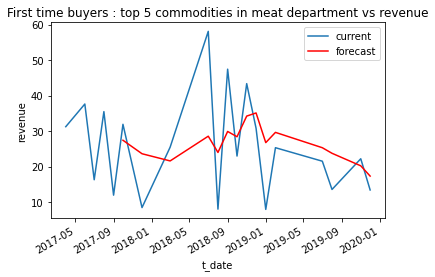

In [43]:
fig, ax = plt.subplots(1,1)
meat_ts.plot(ax=ax);
moving_avg.plot(color = 'red', ax=ax)
plt.title('First time buyers : top 5 commodities in meat department vs revenue')
plt.ylabel('revenue')
plt.legend(['current','forecast'])
plt.show();

the previous figure shows that the shrink in analyzed commodities causes the revenue to shrink and failed the first time customers to convert into loyal ones. supplying the listed commodities in the following department can cause revenue increse.

In [44]:
top_5c[5:10]

,department,commodity,total_revenue
5,Meat,Beef,212.82
6,Meat,Lunch meat,93.46
7,Meat,Chicken,75.67
8,Meat,Pork,71.01
9,Meat,Meat - Other,60.90


# For pharmaceutical trend commodities

In [45]:
top_5c[10:15]

,department,commodity,total_revenue
10,Pharmaceutical,Candy,64.90
11,Pharmaceutical,Vitamins,49.98
12,Pharmaceutical,Diapers,48.22
13,Pharmaceutical,Cigarettes,47.85
14,Pharmaceutical,Audio/video products,39.98


In [46]:
pharmaceutical = dfilt[df.department == 'Pharmaceutical'][dfilt.commodity.str.contains('Candy|Cigarettes|Audio/video products|Vitamins|Diapers')].copy()
pharmaceutical.head()

<ipython-input-46-076b4082a0cc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pharmaceutical = dfilt[df.department == 'Pharmaceutical'][dfilt.commodity.str.contains('Candy|Cigarettes|Audio/video products|Vitamins|Diapers')].copy()


,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
537,15909,1055572,57316,First Time Buyer,2 adults with no kids,19-24,Pharmaceutical,national,Cigarettes,374,2018-10-18,3.69,0,2018-10-01
5096,16752,12263119,59868,First Time Buyer,Single male,19-24,Pharmaceutical,national,Candy,374,2018-11-18,2.50,0,2018-11-01
7580,17249,1103556,62776,First Time Buyer,Single female,25-34,Pharmaceutical,national,Candy,374,2019-12-18,0.99,111,2019-12-01
8039,17344,13158409,57216,First Time Buyer,2 adults with no kids,19-24,Pharmaceutical,national,Candy,374,2017-10-18,2.00,50,2017-10-01
12958,18268,7152455,59869,First Time Buyer,2 adults with kids,19-24,Pharmaceutical,private,Diapers,374,2018-11-18,5.88,0,2018-11-01


In [47]:
pharmaceutical_ts = pharmaceutical.groupby(['t_date']).agg(total_revenue=('price', sum))
pharmaceutical_ts.tail()

,total_revenue
t_date,
2019-07-01,10.96
2019-08-01,6.99
2019-12-01,0.99
2020-04-01,1.79
2020-05-01,3.69


In [48]:
# Calculating the 6month Moving Average 
pharmaceutical_tail = pharmaceutical_ts.rolling(window=6) 
moving_avg = pharmaceutical_tail.mean()
moving_avg.tail(5)

,total_revenue
t_date,
2019-07-01,8.396667
2019-08-01,8.946667
2019-12-01,7.715000
2020-04-01,6.068333
2020-05-01,4.351667


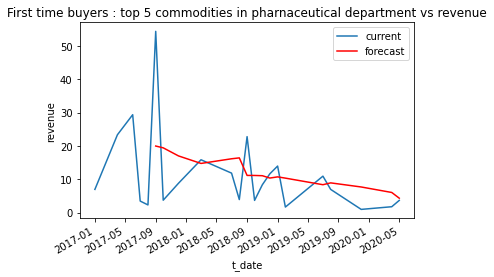

In [49]:
fig, ax = plt.subplots(1,1)
pharmaceutical_ts.plot(ax=ax);
moving_avg.plot(color = 'red', ax=ax)
plt.title('First time buyers : top 5 commodities in pharnaceutical department vs revenue')
plt.ylabel('revenue')
plt.legend(['current','forecast'])
plt.show();

the previous figure shows that the shrink in analyzed commodities causes the revenue to shrink and failed the first time customers to convert into loyal ones. supplying the listed commodities in the following department can cause revenue increse.

In [50]:
top_5c[10:15]

,department,commodity,total_revenue
10,Pharmaceutical,Candy,64.90
11,Pharmaceutical,Vitamins,49.98
12,Pharmaceutical,Diapers,48.22
13,Pharmaceutical,Cigarettes,47.85
14,Pharmaceutical,Audio/video products,39.98
